In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time
from torch.distributions.gamma import Gamma

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
m = Gamma(torch.tensor([4.19495]), torch.tensor([5.64521]))
m.sample()/255 

tensor([0.0014])

In [4]:
#dataset_root_dir = '../dataset/BSDS300/images'
dataset_root_dir_celeb = '/home/anshul/Zeiss/Data3'

In [6]:
# clean.shape

In [7]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(512, 1024), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
#         print(os.path.join(root_dir, mode))
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   

        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)

        m = Gamma(torch.tensor([4.19495]), torch.tensor([5.64521]))
        
        #Generating noisy image, (the noise here is Gamma noise)
        noisy = clean +  m.sample()* torch.randn(clean.shape)
        
        return noisy, clean

In [8]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [10]:
clean = NoisyBSDSDataset(dataset_root_dir_celeb)
test_set = NoisyBSDSDataset(dataset_root_dir_celeb, mode='test_2000', image_size=(512,1024))

In [11]:
type(clean)

__main__.NoisyBSDSDataset

<IPython.core.display.Javascript object>


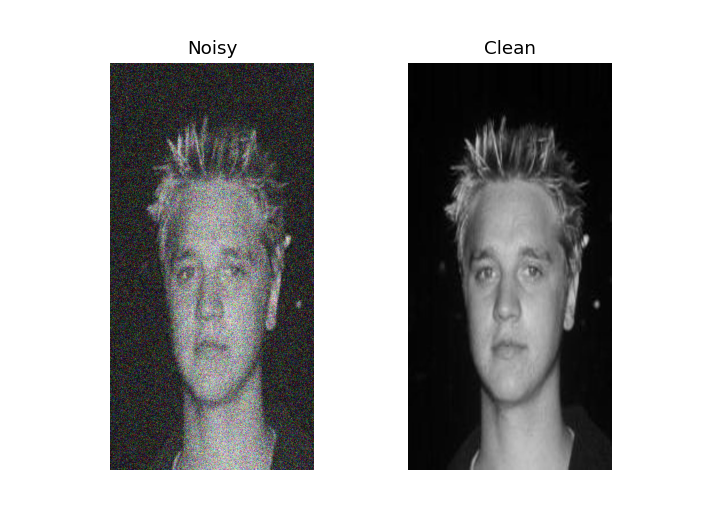

image size is torch.Size([3, 1024, 512]).


In [15]:
x = clean[14]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

<IPython.core.display.Javascript object>


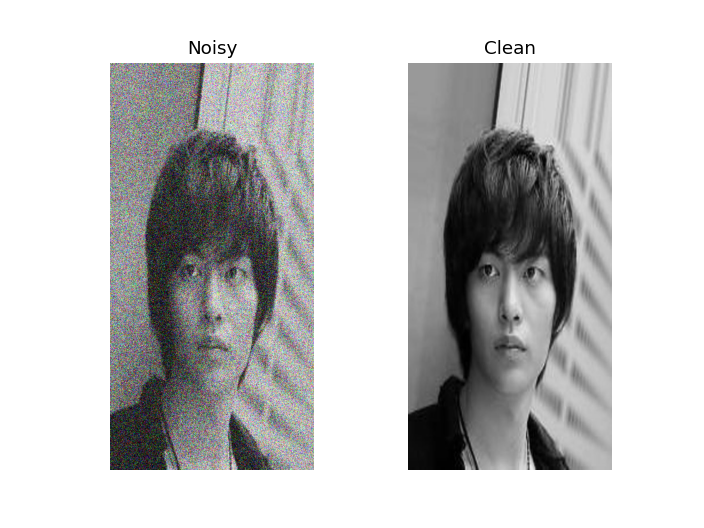

image size is torch.Size([3, 1024, 512]).


In [16]:
x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

<IPython.core.display.Javascript object>


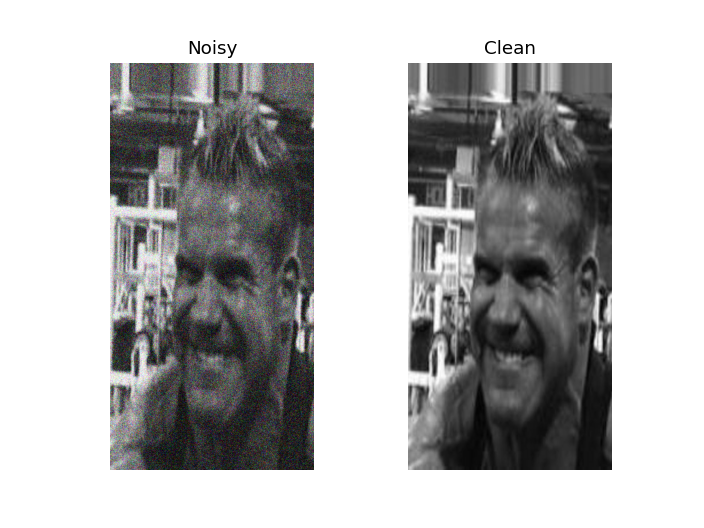

image size is torch.Size([3, 1024, 512]).


In [17]:
x = test_set[13]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

In [20]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

In [21]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

<IPython.core.display.Javascript object>


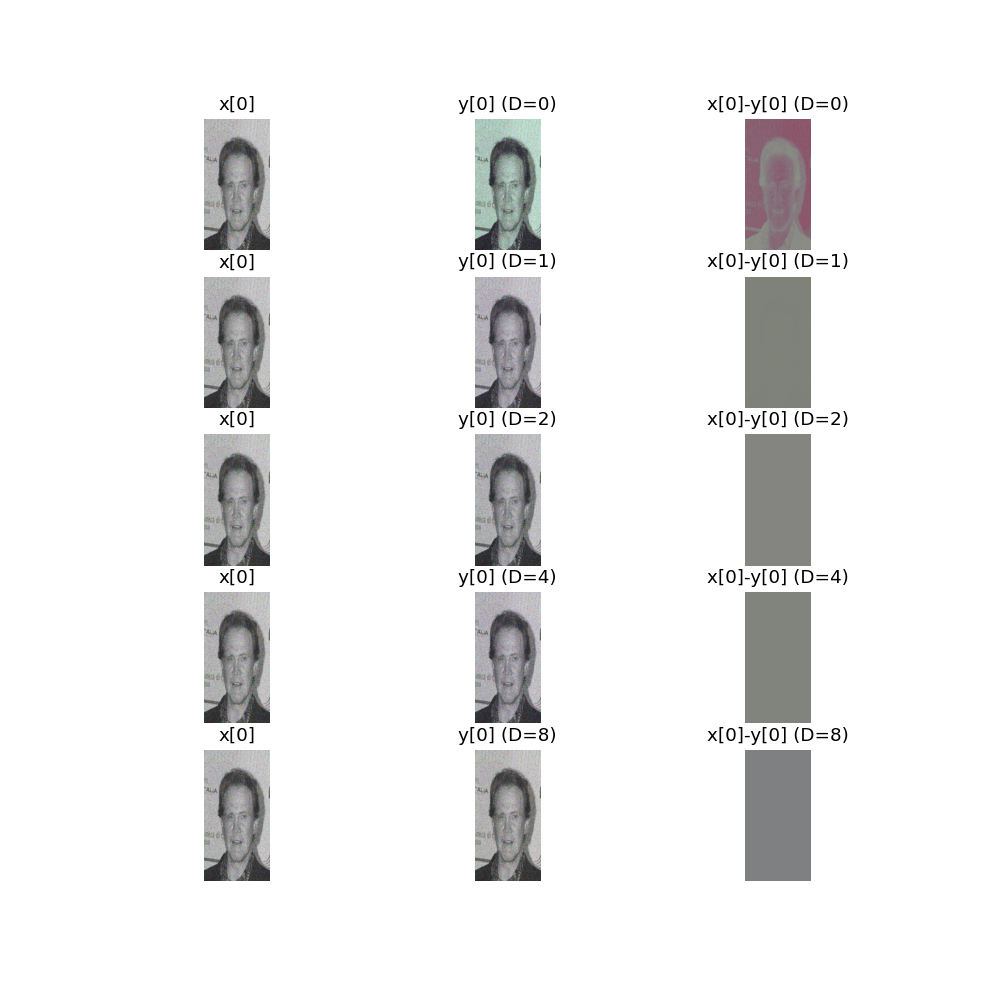

In [22]:
x, _ = clean[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x) # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

In [23]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [24]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

In [25]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, clean, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising_gamma", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


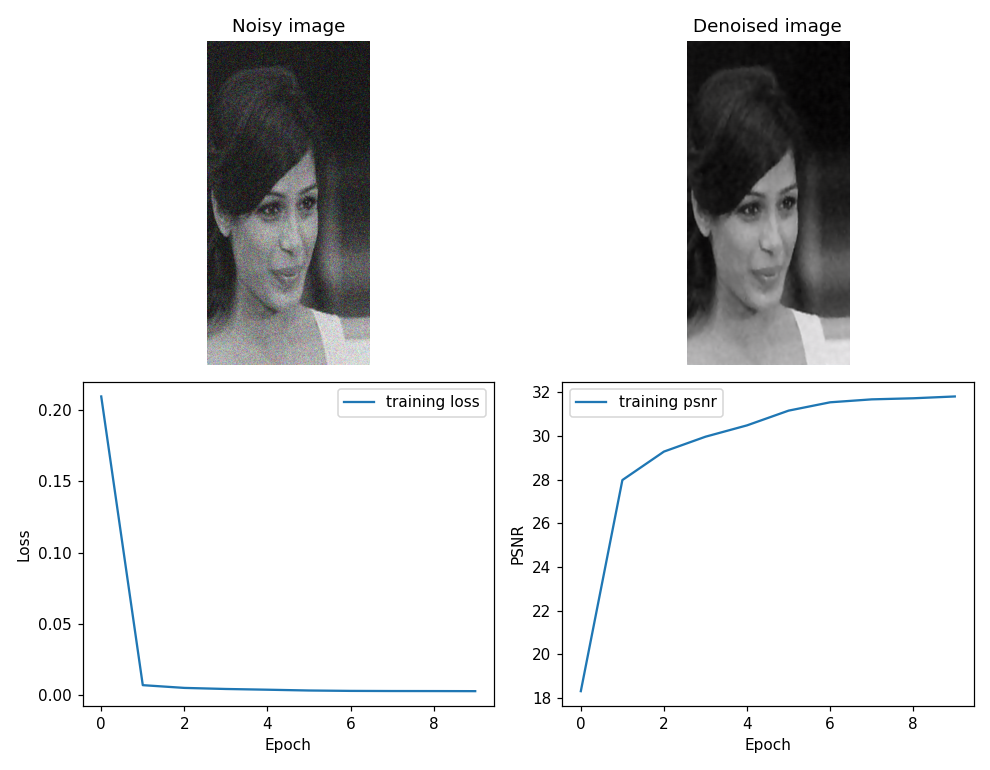

Start/Continue training from epoch 0
Epoch 1 | Time: 727.62s | Training Loss: 0.209493 | Evaluation Loss: 0.008602
Epoch 2 | Time: 724.09s | Training Loss: 0.007021 | Evaluation Loss: 0.006038
Epoch 3 | Time: 725.05s | Training Loss: 0.005095 | Evaluation Loss: 0.004616
Epoch 4 | Time: 724.84s | Training Loss: 0.004340 | Evaluation Loss: 0.006030
Epoch 5 | Time: 724.60s | Training Loss: 0.003828 | Evaluation Loss: 0.003656
Epoch 6 | Time: 724.24s | Training Loss: 0.003275 | Evaluation Loss: 0.003072
Epoch 7 | Time: 723.44s | Training Loss: 0.002999 | Evaluation Loss: 0.003065
Epoch 8 | Time: 722.88s | Training Loss: 0.002903 | Evaluation Loss: 0.002795
Epoch 9 | Time: 723.01s | Training Loss: 0.002873 | Evaluation Loss: 0.002881
Epoch 10 | Time: 723.14s | Training Loss: 0.002813 | Evaluation Loss: 0.003556
Finish training for 10 epochs


In [26]:
#Train model
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

<IPython.core.display.Javascript object>


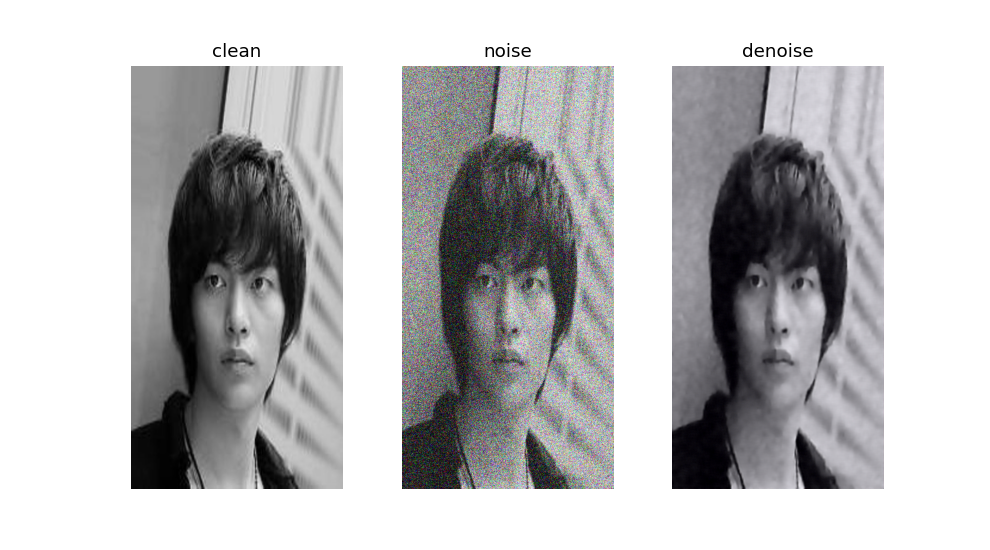

In [27]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[12]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

<IPython.core.display.Javascript object>


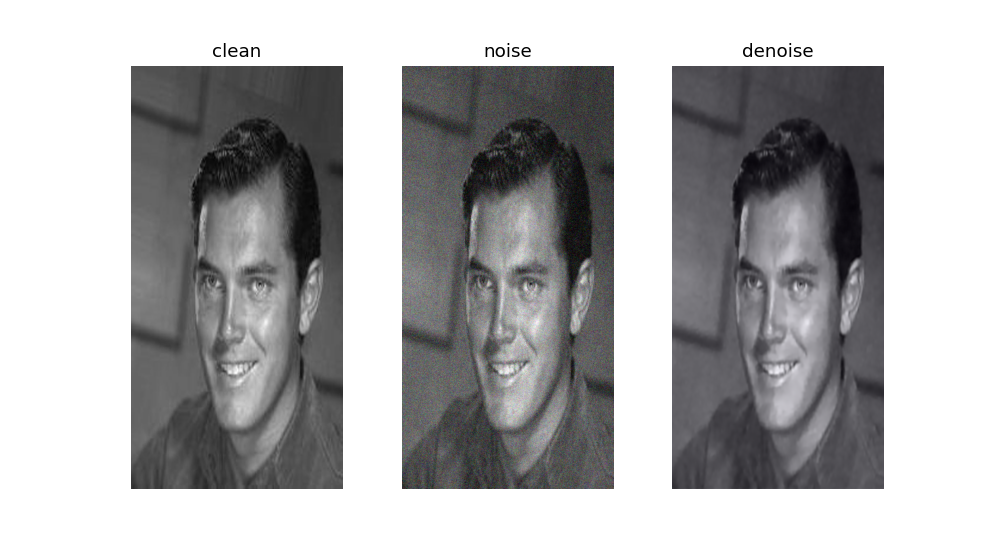

In [29]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[5]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

<IPython.core.display.Javascript object>


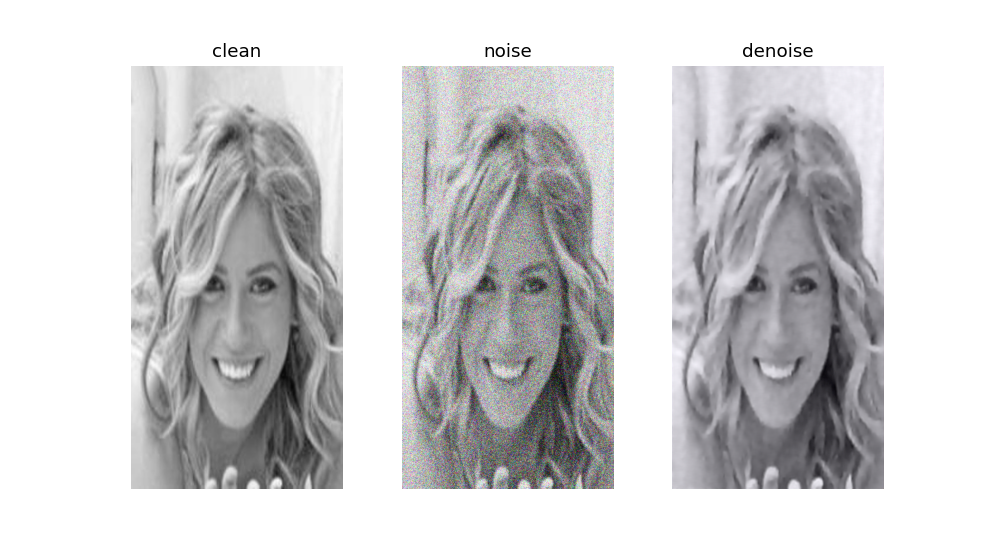

In [31]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[6]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

<IPython.core.display.Javascript object>


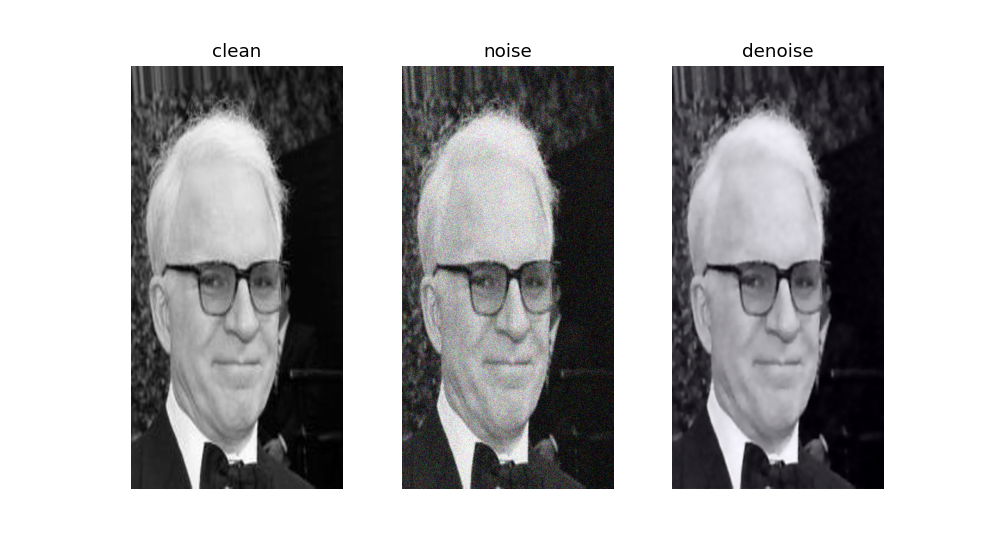

In [32]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[7]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

In [33]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True